## Training a neural network model

In this chapter, you'll learn how to update spaCy's statistical models to customize them for your use case – for example, to predict a new entity type in online comments. You'll train your own model from scratch, and understand the basics of how training works, along with tips and tricks that can make your custom NLP projects more successful.

## Training and updating models: Why update??


Why can't we just rely on pre-trained pipelines? Statistical models make predictions based on the examples they were trained on.

You can usually make the model more accurate by showing it examples from your domain. You often also want to predict categories specific to your problem, so the model needs to learn about them. This is essential for text classification, **very useful for entity recognition** and a little less critical for tagging and parsing.


#### How training works.

spaCy supports updating existing models with more examples, and training new models. If we're not starting with a trained pipeline, we first initialize the weights randomly.

Next, spaCy calls `nlp.update`, which predicts a batch of examples with the current weights.

The model then checks the predictions against the correct answers, and decides how to change the weights to achieve better predictions next time.

Finally, we make a small correction to the current weights and move on to the next batch of examples.

spaCy then continues calling nlp.update for each batch of examples in the data. During training, you usually want to make multiple passes over the data and train until the model stops improving.

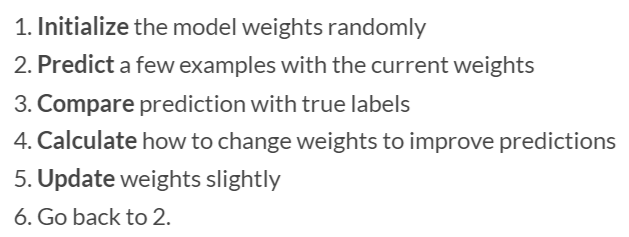


Here's an illustration showing the process.

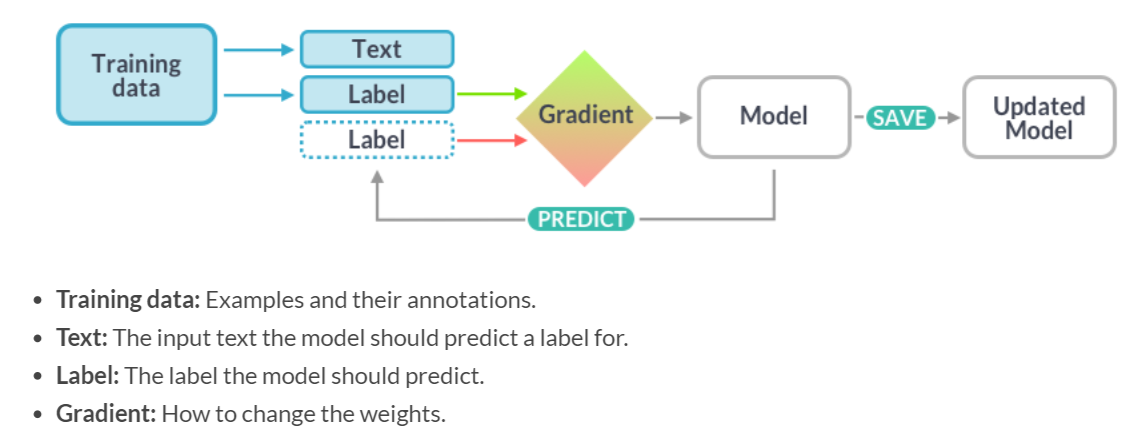

The training data are the examples we want to update the model with.

The text should be a sentence, paragraph or longer document. For the best results, it should be similar to what the model will see at runtime.

The label is what we want the model to predict. This can be a text category, or an entity span and its type.

The gradient is how we should change the model to reduce the current error. It's computed when we compare the predicted label to the true label.

After training, we can then save out an updated model and use it in our application.

#### Example: Training the entity recognizer

Let's look at an example for a specific component: the entity recognizer.

The entity recognizer takes a document and **predicts phrases and their labels in context**. This means that the training data needs to include texts, the entities they contain, and the entity labels.

Entities can't overlap, so each token can only be part of one entity.

The easiest way to do this is to show the model a text and entity spans. spaCy can be updated from regular Doc objects with entities annotated as the doc.ents. For example, "iPhone X" is a gadget, starts at token 0 and ends at token 1.

It's also very important for the model to learn words that aren't entities.

In this case, the list of span annotations will be empty.

Our goal is to teach the model to recognize new entities in similar contexts, even if they weren't in the training data.

In [3]:
import spacy
from spacy.tokens import Span

nlp = spacy.load('en_core_web_sm')

doc = nlp("iPhone X is coming")
doc.ents = [Span(doc, 0, 2, label="GADGET")]

Texts with no entities are also important

In [4]:
doc = nlp("I need a new phone! Any tips?")
doc.ents = []

#### Goal: teach the model to generalize

#### The training data.

The training data tells the model what we want it to predict. This could be **texts** and **named entities** we want to recognize, **tokens** and their correct part-of-speech tags or anything else the model should predict.

To update an existing model, we can start with **a few hundred to a few thousand examples**.

**To train a new category we may need up to a million.**

spaCy's trained English pipelines for instance were trained on **2 million words** labelled with part-of-speech tags, dependencies and named entities.

Training data is usually created by humans who assign labels to texts.

This is a lot of work, but **can be semi-automated – for example, using spaCy's Matcher.**

#### Training vs evaluation data.

When training your model, it's important to know how it's doing and whether it's learning the right thing. This is done by comparing the model's predictions on examples it hasn't seen during training to answers we already know. So in addition to the training data, you also need evaluation data, also called development data.

The evaluation data is used to calculate how accurate your model is. For example, an accuracy score of 90% means that the model predicted 90% of the evaluation examples correctly.

This also means that the evaluation data needs to be representative of the data your model will see at runtime. Otherwise, the accuracy score will be meaningless, because it won't tell you how good your model really is.

#### Generating a training corpus

spaCy can be updated from data in the same format it creates: `Doc` objects. You already learned all about creating Doc and Span objects in chapter 2.

In this example, we're creating two Doc objects for our corpus: one that contains an entity and another one that doesn't contain any entities. To set the entities on the `Doc`, we can add a `Span` to the `doc.ents`.

Of course, you'll need a lot more examples to effectively train your model to generalize and predict similar entities in context. Depending on the task, you usually want at least a few hundred to a few thousand representative examples.

In [5]:
import spacy

nlp = spacy.blank("en")

# Create a Doc with entity spans
doc1 = nlp("iPhone X is coming")
doc1.ents = [Span(doc1, 0, 2, label="GADGET")]
# Create another doc without entity spans
doc2 = nlp("I need a new phone! Any tips?")

docs = [doc1, doc2]  # and so on...

As I mentioned earlier, we don't just need data to train the model. We also want to evaluate its accuracy on examples it hasn't seen during training. This is usually done by shuffling and splitting your data in two: one portion for training and one for evaluation. Here, we're using a simple 50/50 split.

In [7]:
import random 

random.shuffle(docs)

train_docs = docs[:len(docs) // 2]
dev_docs = docs[len(docs) // 2:]

You typically want to store your training and development data as files on disk so you can load them into spaCy's training process.

The `DocBin` is a container for efficiently storing and serializing Doc objects. You can instantiate it with a list of Doc objects and call its to_disk method to save it to a binary file. We typically use the file extension `.spacy` for these files.

Compared to other binary serialization protocols like pickle, the DocBin is faster and produces smaller file sizes because it only stores the shared vocabulary once. You can read more about how it works in the documentation.

In [ ]:
# Create and save a collection of training docs
train_docbin = DocBin(docs=train_docs)
train_docbin.to_disk("./train.spacy")

# Create and save a collection of evaluation docs
dev_docbin = DocBin(docs=dev_docs)
dev_docbin.to_disk("./dev.spacy")

**Converting your data**

In some cases, you might already have training and development data in a common format – for example, CoNLL or IOB. spaCy's convert command automatically converts these files into spaCy's binary format. It also converts JSON files in the old format used by spaCy v2.

`$ python -m spacy convert ./train.gold.conll ./corpus`

**Creating training data**

spaCy’s rule-based Matcher is a great way to quickly create training data for named entity models. A list of sentences is available as the variable TEXTS. You can print it to inspect it. We want to find all mentions of different iPhone models, so we can create training data to teach a model to recognize them as "GADGET".

- Write a pattern for two tokens whose lowercase forms match "iphone" and "x".
- Write a pattern for two tokens: one token whose lowercase form matches "iphone" and a digit.

In [9]:
TEXTS = ['How to preorder the iPhone X', 'iPhone X is coming', 'Should I pay $1,000 for the iPhone X?', 'The iPhone 8 reviews are here', "iPhone 11 vs iPhone 8: What's the difference?", 'I need a new phone! Any tips?']

In [10]:
import json
import spacy
from spacy.matcher import Matcher
from spacy.tokens import Span

#with open("exercises/en/iphone.json", encoding="utf8") as f:
#    TEXTS = json.loads(f.read())

nlp = spacy.blank("en")
matcher = Matcher(nlp.vocab)

# Two tokens whose lowercase forms match "iphone" and "x"
pattern1 = [{"LOWER": "iphone"}, {"LOWER": "x"}]

# Token whose lowercase form matches "iphone" and a digit
pattern2 = [{"LOWER": "iphone"}, {"IS_DIGIT": True}]

# Add patterns to the matcher and create docs with matched entities
matcher.add("GADGET", [pattern1, pattern2])

docs = []
for doc in nlp.pipe(TEXTS):
    matches = matcher(doc)
    spans = [Span(doc, start, end, label=match_id) for match_id, start, end in matches]
    print(spans)
    doc.ents = spans
    docs.append(doc)

[iPhone X]
[iPhone X]
[iPhone X]
[iPhone 8]
[iPhone 11, iPhone 8]
[]


After creating the data for our corpus, we need to save it out to a .spacy file. The code from the previous example is already available.

- Instantiate the DocBin with the list of docs.
- Save the `DocBin` to a file called `train.spacy.`

In [11]:
import json
import spacy
from spacy.matcher import Matcher
from spacy.tokens import Span, DocBin

#with open("exercises/en/iphone.json", encoding="utf8") as f:
#    TEXTS = json.loads(f.read())

nlp = spacy.blank("en")
matcher = Matcher(nlp.vocab)
# Add patterns to the matcher
pattern1 = ([{"LOWER": "iphone"}, {"LOWER": "x"}])
pattern2 = [{"LOWER": "iphone"}, {"IS_DIGIT": True}]
matcher.add("GADGET", [pattern1, pattern2])
docs = []
for doc in nlp.pipe(TEXTS):
    matches = matcher(doc)
    spans = [Span(doc, start, end, label=match_id) for match_id, start, end in matches]
    doc.ents = spans
    docs.append(doc)

doc_bin = DocBin(docs=docs)
doc_bin.to_disk("./train.spacy")

#### Configuring and running the training.

Let's take a look at training your pipeline and configuring the training. In this lesson, you'll learn all about spaCy's training config system, how to generate your own training config, how to use the CLI to train a model and how to explore your trained pipeline afterwards.

**The training config**

spaCy uses a config file, usually called `config.cfg`, as the "single source of truth" for all settings. The config file defines how to initialize the `nlp` object, which pipeline components to add and how their internal model implementations should be configured. It also includes all settings for the training process and how to load the data, including hyperparameters.

Instead of providing lots of arguments on the command line or having to remember to define every single setting in code, you only need to pass your config file to spaCy's training command.

Config files also help with **reproducibility**: you'll have all settings in one place and always know how your pipeline was trained. You can even check your config file into a Git repo to version it and share it with others so they can train the same pipeline with the same settings.

Here's an excerpt from a config file used to train a pipeline with a named entity recognizer. The config is grouped into sections, and nested sections are defined using a dot. For example, [components.ner.model] defines the settings for the named entity recognizer's model implementation.

Config files can also reference Python functions using the `@` notation. For example, the tokenizer defines a registered tokenizer function. You can use this to customize different parts of the nlp object and training – from plugging in your own tokenizer, all the way to implementing your own model architectures. But let's not worry about this for now – what you'll learn in this chapter will simply use the defaults spaCy provides out-of-the-box!

```
[nlp]
lang = "en"
pipeline = ["tok2vec", "ner"]
batch_size = 1000

[nlp.tokenizer]
@tokenizers = "spacy.Tokenizer.v1"

[components]

[components.ner]
factory = "ner"

[components.ner.model]
@architectures = "spacy.TransitionBasedParser.v2"
hidden_width = 64
# And so on...
```

**Generating a config**

Of course, you don't have to write the config files by hand, and in a lot of cases, you won't even need to customize it at all. **spaCy can auto-generate a config file for you.**

The quickstart widget in the documentation lets you generate a config interactively by selecting the language and pipeline components you need, as well as optional hardware and optimization settings.

Alternatively, you can also use spaCy's built-in `init` config command. It takes the output file as the first argument. We usually call this file config.cfg. The argument --lang defines the language class that should be used for the pipeline, for example, en for English. The --pipeline argument lets you specify one or more comma-separated pipeline components to include. In this example, we're creating a config with one pipeline component, the named entity recognizer.

`$ python -m spacy init config ./config.cfg --lang en --pipeline ner`

**Training a pipeline**

To train a pipeline, all you need is the config file and the training and development data. These are the .spacy files you already worked with in the previous exercises.

The first argument of spacy train is the path to the config file. The `--output` argument lets you specify a directory for saving the final trained pipeline.

You can also override different config settings on the command line. In this case, we override `paths.train` using the path to the `train.spacy` file and `paths.dev` using the `dev.spacy` file.

`$ python -m spacy train ./config.cfg --output ./output --paths.train train.spacy --paths.dev dev.spacy`

- `train`: the command to run
- `config.cfg`: the path to the config file
- `--output`: the path to the output directory to save the trained pipeline
- `--paths.train`: override with path to the training data
- `--paths.dev`: override with path to the evaluation data

Here's an example of the output you'll see during and after training. You might remember from earlier in this chapter that you usually want to make several passes over the data during training. Each pass over the data is also called an "epoch". This is shown in the first column of the table.

Within each epoch, spaCy outputs the accuracy scores every 200 examples. These are the steps shown in the second column. You can change the frequency in the config. Each line shows the loss and calculated accuracy score at this point during training.

The most interesting score to keep an eye on is the combined score in the last column. It reflects how accurately your model predicted the correct answers in the evaluation data.

The training runs until the model stops improving and exits automatically.

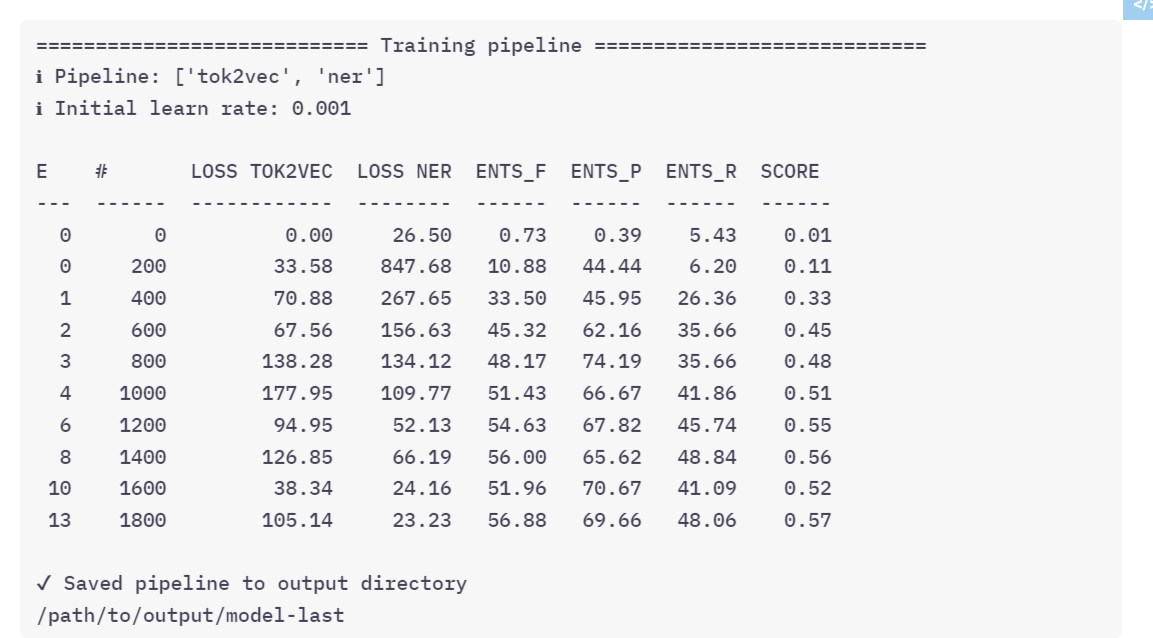

**Loading a trained pipeline**

The pipeline saved after training is a regular loadable spaCy pipeline – just like the trained pipelines provided by spaCy, for example `en_core_web_sm`. At the end, the last trained pipeline and the pipeline with the best score is saved to the output directory.

You can load your trained pipeline by passing the path to spacy.load. You can then use it to process and analyze text.

In [ ]:
import spacy

nlp = spacy.load("/path/to/output/model-best")
doc = nlp("iPhone 11 vs iPhone 8: What's the difference?")
print(doc.ents)

**Tip: Packaging your pipeline**

To make it easy to deploy your pipelines, spaCy provides a handy command to package them as Python packages. The spacy package command takes the path to your exported pipeline and an output directory. It then generates a Python package containing your pipeline. The Python package is a .tar.gz file and can be installed into your environment.

You can also provide an optional name and version on the command. This lets you manage multiple different versions of a pipeline, for example, if you decide to customize your pipeline later or train it with more data.

The package behaves just like any other Python package. After installation, you can load your pipeline using its name. Note that spaCy will automatically add the language code to the name. So your pipeline my_pipeline will become en_my_pipeline.

`$ python -m spacy package /path/to/output/model-best ./packages --name my_pipeline --version 1.0.0`

```
$ cd ./packages/en_my_pipeline-1.0.0
$ pip install dist/en_my_pipeline-1.0.0.tar.gz
```

Load and use:

`nlp = spacy.load("en_my_pipeline")`

**The training config**

The init config command auto-generates a config file for training with the default settings. We want to train a named entity recognizer, so we’ll generate a config file for one pipeline component, ner.

- Use spaCy’s `init config` command to auto-generate a config for an English pipeline.
- Save the config to a file `config.cfg`.
- Use the `--pipeline` argument to specify one pipeline component, `ner`.

In [12]:
!python -m spacy init config ./config.cfg --lang en --pipeline ner

⚠ To generate a more effective transformer-based config (GPU-only),
install the spacy-transformers package and re-run this command. The config
generated now does not use transformers.
ℹ Generated config template specific for your use case
- Language: en
- Pipeline: ner
- Optimize for: efficiency
- Hardware: CPU
- Transformer: None
✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


Let’s take a look at the config spaCy just generated! You can run the command below to print the config to the terminal and inspect it.

In [13]:
!cat ./config.cfg

[paths]
train = null
dev = null
vectors = null
init_tok2vec = null

[system]
gpu_allocator = null
seed = 0

[nlp]
lang = "en"
pipeline = ["tok2vec","ner"]
batch_size = 1000
disabled = []
before_creation = null
after_creation = null
after_pipeline_creation = null
tokenizer = {"@tokenizers":"spacy.Tokenizer.v1"}

[components]

[components.ner]
factory = "ner"
incorrect_spans_key = null
moves = null
scorer = {"@scorers":"spacy.ner_scorer.v1"}
update_with_oracle_cut_size = 100

[components.ner.model]
@architectures = "spacy.TransitionBasedParser.v2"
state_type = "ner"
extra_state_tokens = false
hidden_width = 64
maxout_pieces = 2
use_upper = true
nO = null

[components.ner.model.tok2vec]
@architectures = "spacy.Tok2VecListener.v1"
width = ${components.tok2vec.model.encode.width}
upstream = "*"

[components.tok2vec]
factory = "tok2vec"

[components.tok2vec.model]
@architectures = "spacy.Tok2Vec.v2"

[components.tok2vec.model.embed]
@architectures = "spacy.MultiHashEmbed.v2"
width = ${compon

**Using the trainig CLI**

Let’s use the config file generated in the previous exercise and the training corpus we’ve created to train a named entity recognizer!

The `train` command lets you train a model from a training config file. A file `config_gadget.cfg` is already available in the directory exercises/en, as well as a file `train_gadget.spacy` containing the training examples, and a file `dev_gadget.spacy` containing the evaluation examples.

- Call the train command with the file exercises/en/config_gadget.cfg.
- Save the trained pipeline to a directory output.
- Pass in the exercises/en/train_gadget.spacy and exercises/en/dev_gadget.spacy paths.

In [ ]:
!python -m spacy train ./exercises/en/config_gadget.cfg --output ./output --paths.train ./exercises/en/train_gadget.spacy --paths.dev ./exercises/en/dev_gadget.spacy

**Exploring the model**

Let’s see how the model performs on unseen data! To speed things up a little, we already ran a trained pipeline for the label "GADGET" over some text. Here are some of the results:

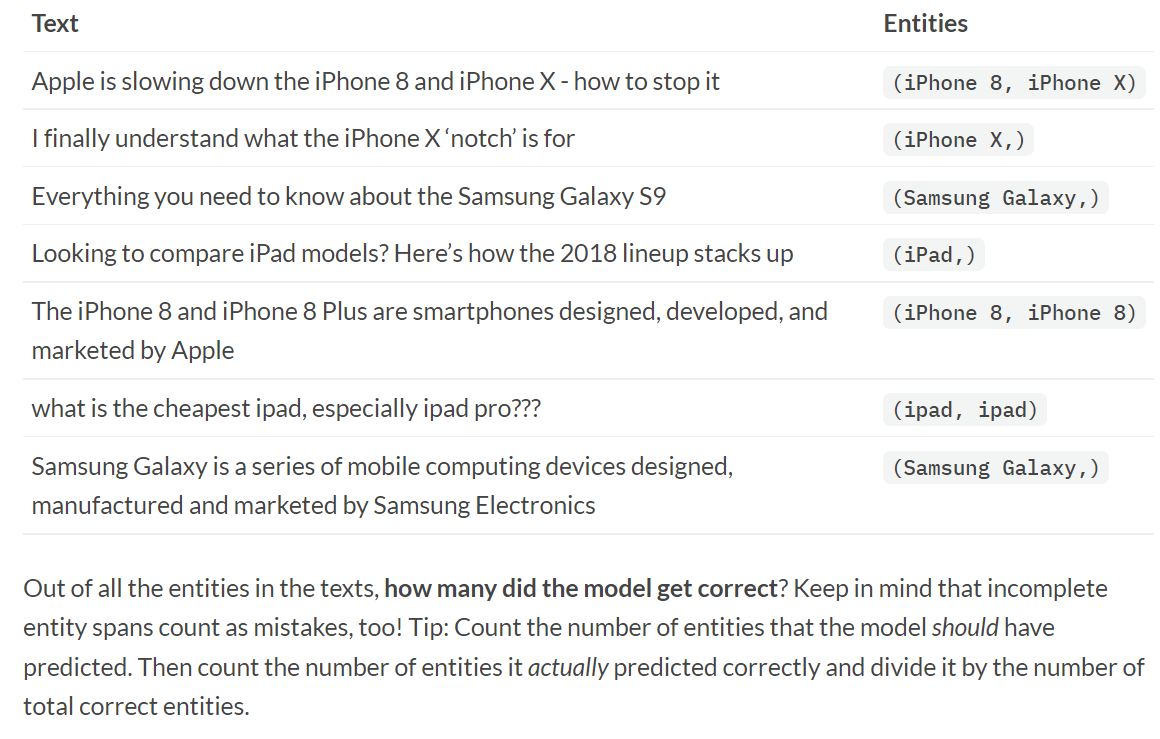

**Best practices...**
**Good vs bad data**
**Multiple labels**